In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, c, e
import os
from PIL import Image
import numpy as np
import pandas as pd

# Example usage:
# Assuming phase space data is loaded into 'phase_space_data' and third cosine direction is known as 'third_cosine_direction'

# phase_space_data = ... # Load phase space data
# third_cosine_direction = ... # 0 or 1 indicating if pz is positive or negative

# Correct angular dependence
# corrected_weights = correct_angular_dependence(phase_space_data, third_cosine_direction)


def process_phsp_file(filename):
    with open(filename, 'r') as file:

        # Initialize lists to store extracted data
        energies = []
        positions = []
        direction_cosines = []
        
        for line in file:
            # Split the line into columns
            columns = line.split()  # Assuming space-separated values

            # Check if the line corresponds to a photon
            if columns[7] == '-22':  
                energy = float(columns[5])  # Energy in MeV
                position = (float(columns[0]), float(columns[1]), float(columns[2]))  # Positions X, Y, Z
                direction_cosine = (float(columns[3]), float(columns[4]), float(columns[8]))  # Direction cosines X, Y, Z
                energies.append(energy)
                positions.append(position)
                direction_cosines.append(direction_cosine)

    # Here you can process the extracted data further or save it, etc.
    return energies, positions, direction_cosines


def Mev_to_wavelength(energy_Mev):
    # Convert energy from eV to wavelength in meters
    energy_joules = 10**6 * energy_Mev * e
    wavelength_m = h * c / energy_joules
    return wavelength_m

def create_histogram(data, bins):
    # Accumulate the photons in a 2D histogram
    # Assuming data contains x, y positions
    histogram, _, _ = np.histogram2d(data[:,1], data[:,2], bins=bins)
    return histogram

def simulate_camera(histogram, intrinsic_params, extrinsic_params):
    # Simulate the virtual camera recording the photons
    # This is a placeholder function; you need to implement the camera model
    # using the intrinsic and extrinsic parameters provided
    # This function should project the 2D histogram onto the camera sensor
    camera_image = np.zeros_like(histogram)  # Placeholder for the camera image
    return camera_image

# Function to load saved images
def load_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".tif"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            
            # Extracting mus and mua from filename
            mus_mua = filename.split("_mus_")[-1].split("_mua_")
            mus = mus_mua[0]
            mua = mus_mua[1].split(".tif")[0]
            images.append((mus, mua, np.array(image)))
    return images

def correct_angular_dependence(px,py,flag):
    """
    Corrects angular dependence in phase space data.
    
    Parameters:
        phase_space_data (numpy.ndarray): Phase space data array with shape (N, 6),
            where N is the number of particles and 6 represents (x, y, z, px, py, pz).
        third_cosine_direction (int): Third cosine direction indicating if pz is positive (1) or negative (0).
    
    Returns:
        numpy.ndarray: Corrected weights based on angle of incidence.
    """

    if(flag): 
        # Photon is traveling inwards of the z direction
        pz_sign = -1
    else:
        # Photon is traveling outwards of the z direction
        pz_sign = 1


    # Calculate pz
    pz = pz_sign * np.sqrt(1 - px**2 - py**2)

    # Calculate dot product of photon direction with reference direction (z-axis)
    dot_product = np.abs(pz / np.sqrt(px**2 + py**2 + pz**2))
    
    # Apply correction: 1 for orthogonal photons, 0 for parallel photons
    weights = 1 - dot_product
    
    polar_angle = np.arccos(pz / np.sqrt(px**2 + py**2 + pz**2))
    polar_angle_degrees = np.degrees(polar_angle)
    cosine_polar_angle = np.cos(np.radians(polar_angle_degrees))

    return cosine_polar_angle

    #return weights

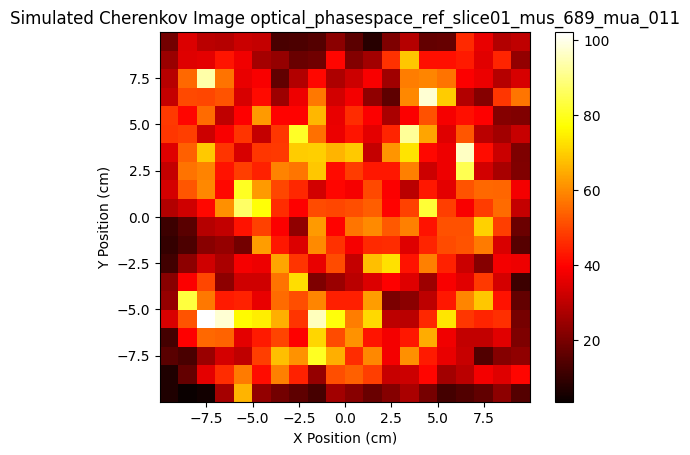

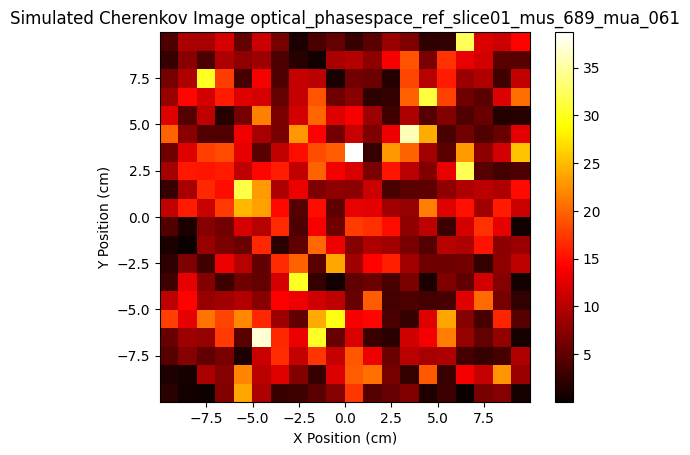

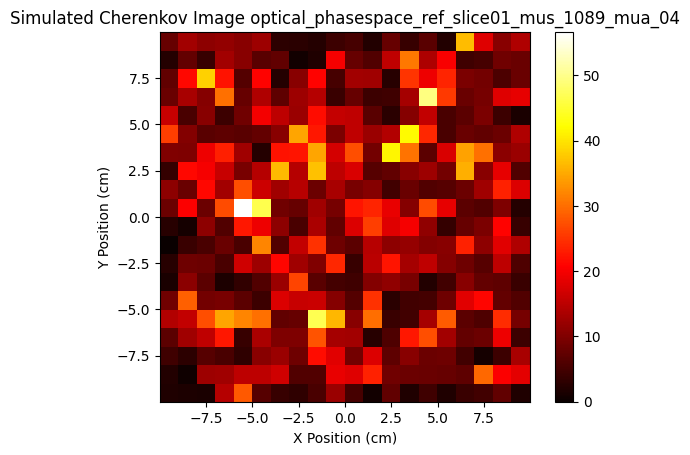

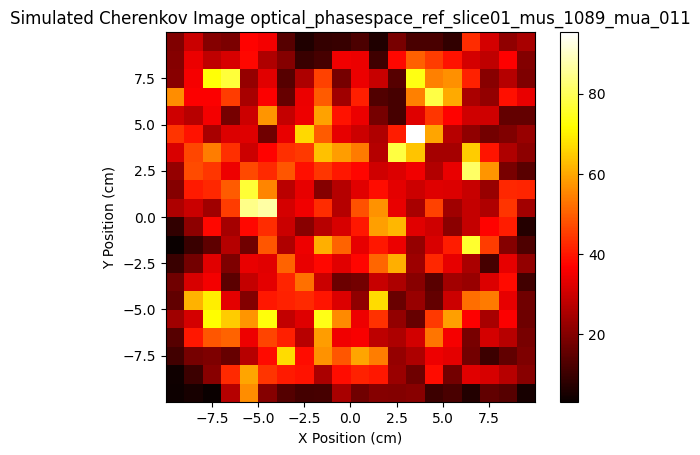

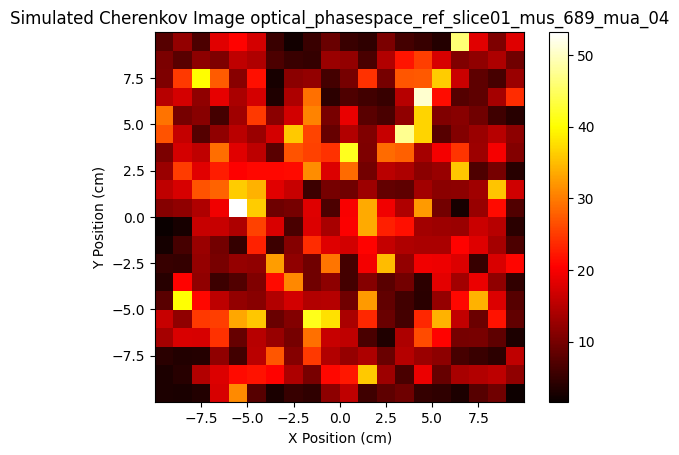

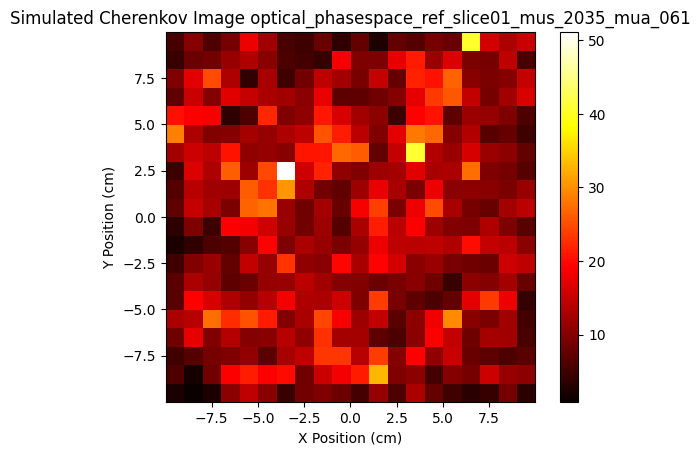

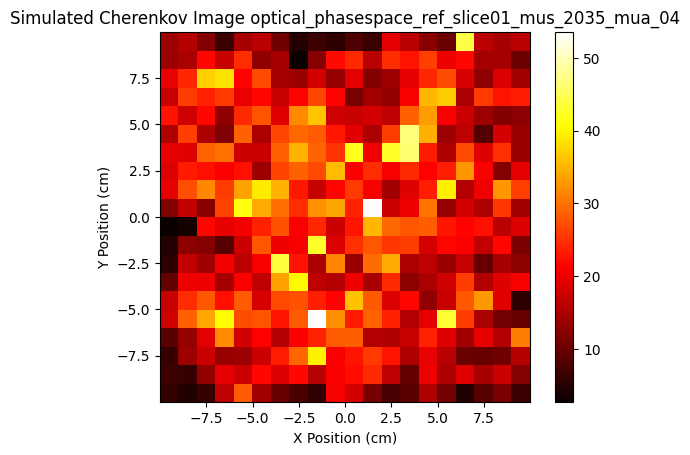

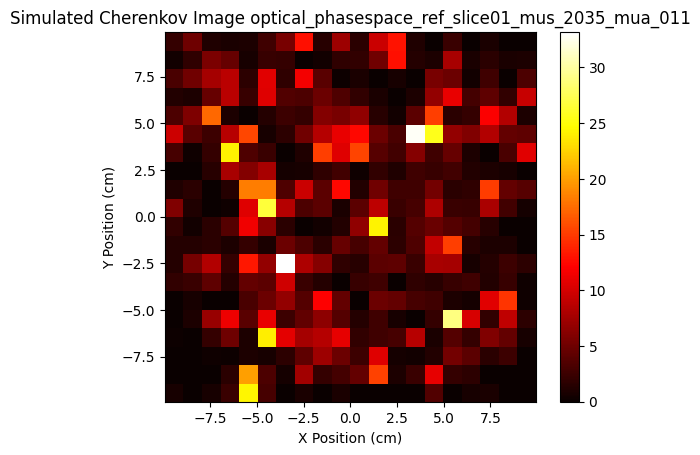

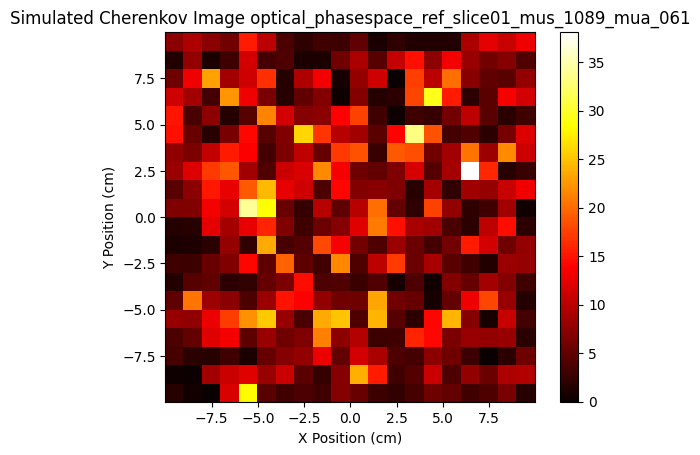

In [130]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# Define the directory containing the files
directory = "/Applications/topas/OpticalPhantomExperiment/Output/"

# Initialize a list to store filenames
filenames = []


# Look up the quantum efficiency for each wavelength
gen3 = pd.read_csv('gen3.csv', header=None,  names=['wavelength','QE'])

    # Create the interpolation function
interpolated_function = interp1d(gen3['wavelength'], gen3['QE'] / max(gen3['QE']), kind='linear')


# Main workflow
for item in os.listdir(directory):
    if item.startswith("optical_phasespace_ref_slice01") and item.endswith(".phsp"):
        filenames.append(item)

# Loop through each filename
for filename in filenames:
    phantomname = filename.split(".")[0]

    fullfilename = os.path.join(directory, filename)

    # Get out energies, positions, and direction_cosigns
    energies, positions, direction_cosines = process_phsp_file(fullfilename)

    # Convert energy to wavelength
    wavelengths = 10**9 * np.array([Mev_to_wavelength(energy) for energy in energies])

    # Convert direction cosines to angular correction
    angular_weights = [correct_angular_dependence(direction_cosines[row][0], direction_cosines[row][1], direction_cosines[row][2]) for row in range(len(direction_cosines))]

    # Filter energies and positions based on wavelengths between 400 and 800 nm
    filtered_indices = np.where((wavelengths >= 414) & (wavelengths <= 794))[0]
    filtered_directions = []
    filtered_energies = []
    filtered_wavelengths = []
    filtered_positions = []
    filtered_angular_weights = []
    filtered_qe_weights = []

    # Fileter the energies and weights
    for f in filtered_indices.tolist():
        filtered_energies.append(energies[f]) 
        filtered_wavelengths.append(wavelengths[f]) 
        filtered_positions.append(positions[f])
        filtered_angular_weights.append(angular_weights[f])
        filtered_directions.append(direction_cosines[f])
        filtered_qe_weights.append(interpolated_function(wavelengths[f]))

   
    # Calculate the histogram for filtered positions
    bins = 20
    filtered_histogram, xedges, yedges = np.histogram2d(
        [row[0] for row in filtered_positions],  # x positions
        [row[1] for row in filtered_positions],  # y positions
        bins=[bins, bins],  # specifying the bin size for both dimensions
        weights=np.array(filtered_angular_weights) * np.array(filtered_qe_weights)  # applying angular and QE weights
    )

    plt.imshow(filtered_histogram.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')
    plt.colorbar()
    plt.title("Simulated Cherenkov Image " + phantomname)
    plt.xlabel("X Position (cm)")
    plt.ylabel("Y Position (cm)")
    plt.show()

    # Uncomment the following lines if you want to save the images
    # Convert the numpy array to a PIL image
    image = Image.fromarray(np.uint16(filtered_histogram))
    
    # Save the image
    output_path = os.path.join("/Applications/topas/OpticalPhantomExperiment/OutputCherenkovImages/",
                               'Cherenkov_image' + phantomname + '.tif')
    image.save(output_path)




array([0.52622058, 0.00367394, 0.3067648 , ..., 0.10313555, 0.0344249 ,
       0.3306983 ])

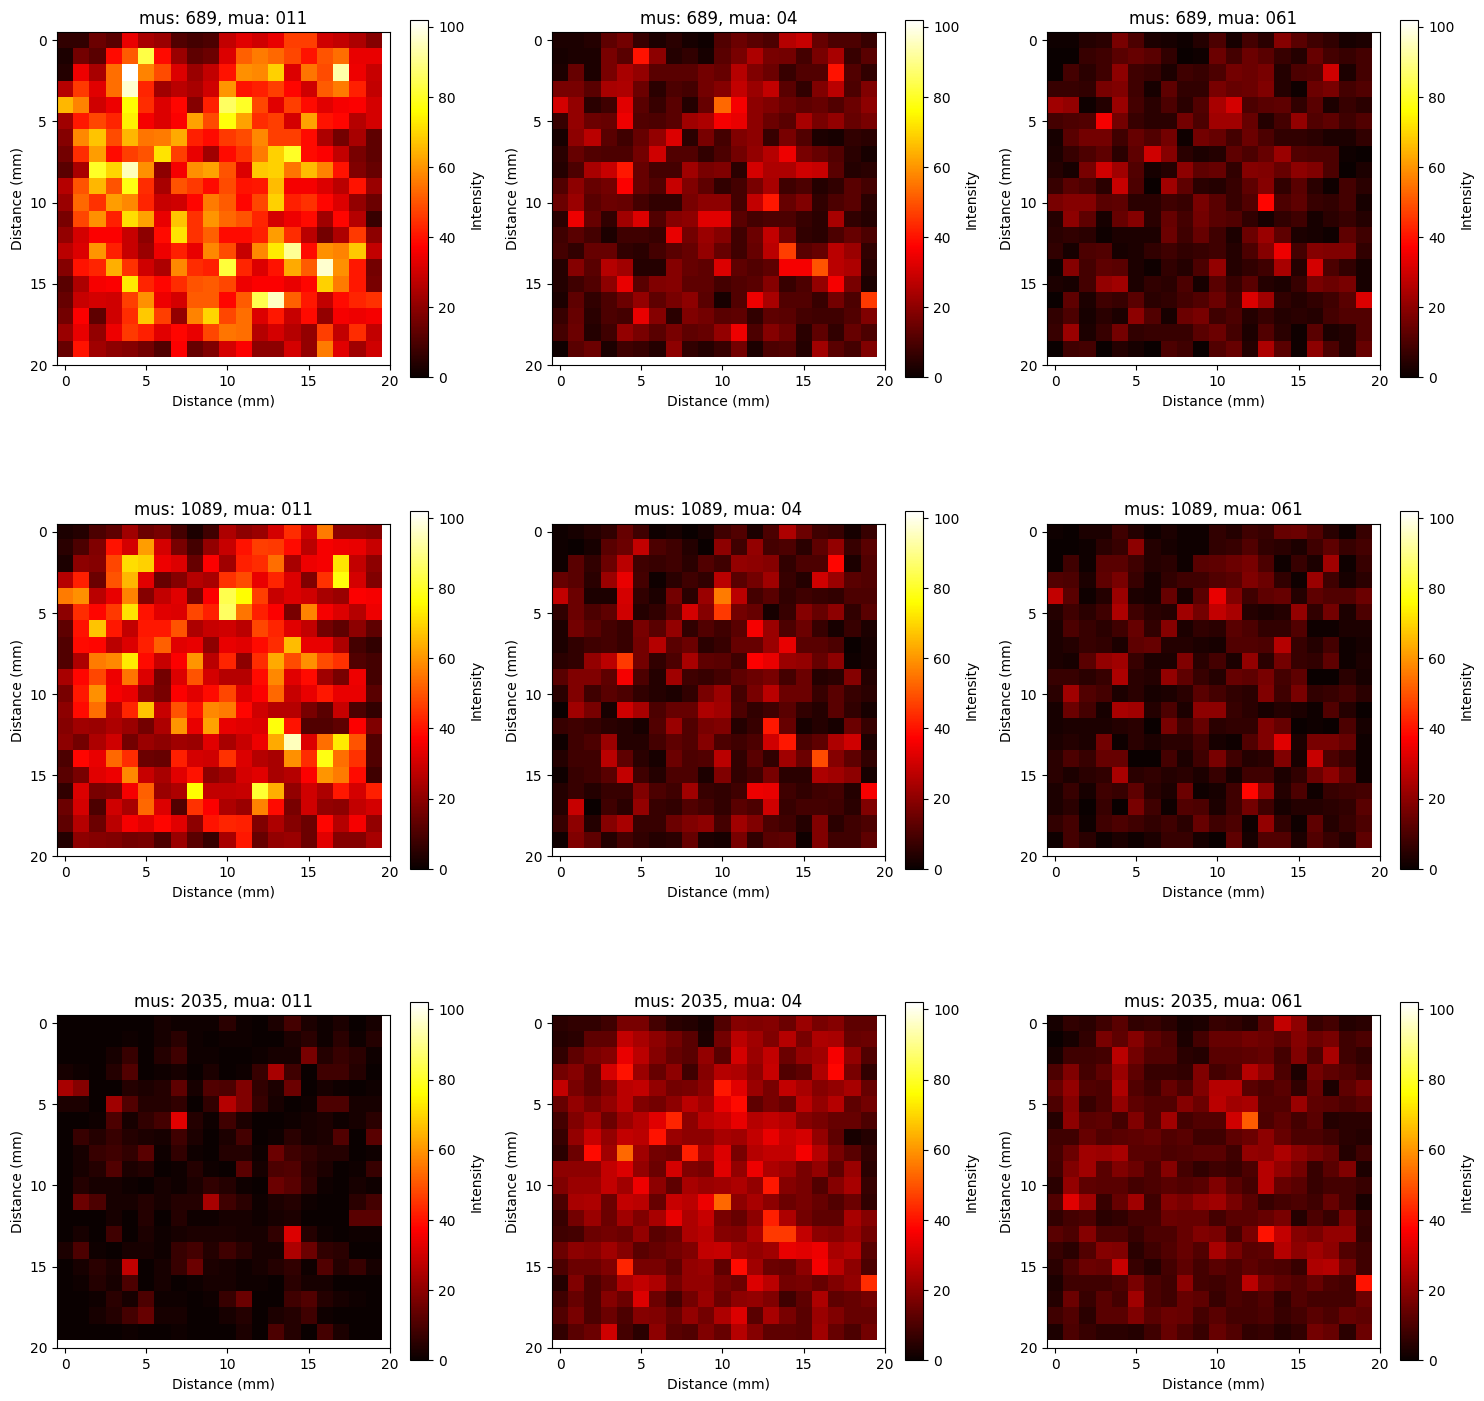

In [132]:

# Load saved images and make 3x3 montage
image_folder = '/Applications/topas/OpticalPhantomExperiment/OutputCherenkovImages/'
images = load_images(image_folder)

# Sort images based on custom criteria
images.sort(key=lambda x: (int(x[1]), int(x[0])))

# Get the minimum and maximum values of histograms across all images
min_value = min(np.min(image[2]) for image in images)
max_value = max(np.max(image[2]) for image in images) 

# Create a 3x3 montage plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Set the distance for each box (assuming each pixel represents 5 mm)
distance = bins / 20  # in mm

# Reorder images so that mua_011 is in the first column, mua_04 is in the second column, and mua_061 is in the third column
images_reordered = [images[i] for i in [3, 0, 6,
                                         4, 1, 7, 
                                         5, 2, 8]]

# Plot each image with labels and color bar
for (mus, mua, image), ax in zip(images_reordered, axes.flat):
    im = ax.imshow(image, cmap='hot', vmin=min_value, vmax=max_value)
    ax.set_title(f"mus: {mus}, mua: {mua}")  # Set title with mus and mua values
    ax.set_xlabel('Distance (mm)')
    ax.set_ylabel('Distance (mm)')
    ax.set_xticks(np.linspace(0, image.shape[1], 5))  # Adjusted tick locations
    ax.set_yticks(np.linspace(0, image.shape[0], 5))  # Adjusted tick locations
    ax.set_xticklabels(np.linspace(0, image.shape[1] * distance, 5).astype(int))
    ax.set_yticklabels(np.linspace(0, image.shape[0] * distance, 5).astype(int))
    # Add a colorbar to each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75)
    cbar.set_label('Intensity')

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('3x3_montage.png')

# Show the plot
plt.show()





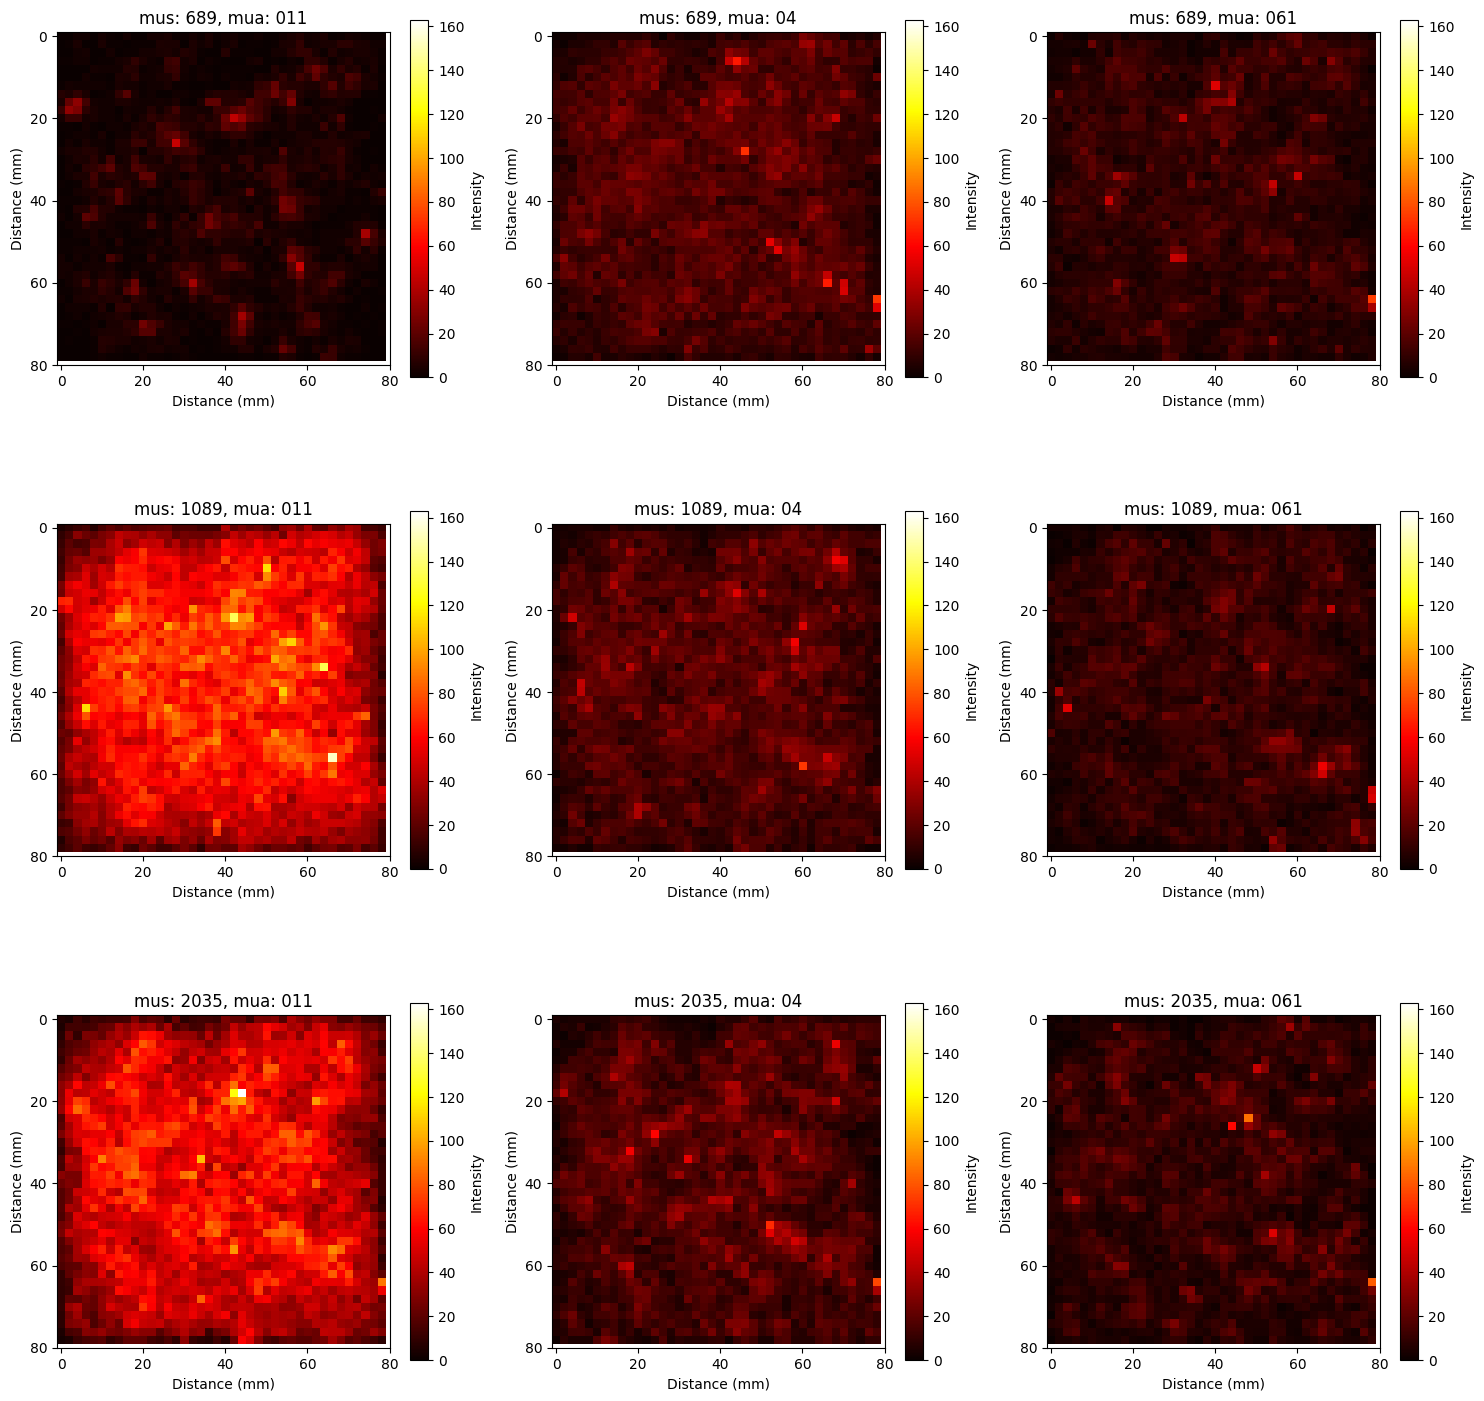

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to load saved images
def load_images(image_folder):
    images = []
    for filename in os.listdir(image_folder):
        if filename.endswith(".tif"):
            image_path = os.path.join(image_folder, filename)
            image = Image.open(image_path)
            
            # Extracting mus and mua from filename
            mus_mua = filename.split("_mus_")[-1].split("_mua_")
            mus = mus_mua[0]
            mua = mus_mua[1].split(".tif")[0]
            images.append((mus, mua, np.array(image)))
    return images

# Load saved images
image_folder = '/Applications/topas/OpticalPhantomExperiment/OutputCherenkovImages/'
images = load_images(image_folder)

# Sort images based on custom criteria
images.sort(key=lambda x: (int(x[1]), int(x[0])))

# Get the minimum and maximum values of histograms across all images
min_value = min(np.min(image[2]) for image in images)
max_value = max(np.max(image[2]) for image in images) 


# Create a 3x3 montage plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Set the distance for each box (assuming each pixel represents 5 mm)
distance = bins / 20  # in mm

# Reorder images so that mua_011 is in the first column, mua_04 is in the second column, and mua_061 is in the third column
images_reordered = [images[i] for i in [3, 0, 6,
                                         4, 1, 7, 
                                         5, 2, 8]]

# Plot each image with labels and color bar
for (mus, mua, image), ax in zip(images_reordered, axes.flat):
    im = ax.imshow(image, cmap='hot', vmin=min_value, vmax=max_value)
    ax.set_title(f"mus: {mus}, mua: {mua}")  # Set title with mus and mua values
    ax.set_xlabel('Distance (mm)')
    ax.set_ylabel('Distance (mm)')
    ax.set_xticks(np.linspace(0, image.shape[1], 5))  # Adjusted tick locations
    ax.set_yticks(np.linspace(0, image.shape[0], 5))  # Adjusted tick locations
    ax.set_xticklabels(np.linspace(0, image.shape[1] * distance, 5).astype(int))
    ax.set_yticklabels(np.linspace(0, image.shape[0] * distance, 5).astype(int))
    # Add a colorbar to each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75)
    cbar.set_label('Intensity')

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('3x3_montage.png')

# Show the plot
plt.show()





In [120]:

# NEED TO SIMULATE CAMERA HERE
# Add in efficiency, convolution kernel, and cosine effect (angular correction)

# Define your camera's intrinsic and extrinsic properties
intrinsic_params = {"param1": value1, "param2": value2}  # Placeholder values
extrinsic_params = {"param1": value1, "param2": value2}  # Placeholder values

# Simulate the camera recording the photons
camera_image = simulate_camera(histogram, intrinsic_params, extrinsic_params)

# Display the camera image
plt.imshow(camera_image, cmap='hot')
plt.colorbar()
plt.title("Simulated Camera Image")
plt.show()


NameError: name 'value1' is not defined